# <font color=blue>OPTIM/OPTECH Laboratory Project Session I: </font>
## <font color=blue>NETWORK OPTIMIZATION</font>

### `MASTEAM`: Master's degree in Applied Telecommunications and Engineering Management
### `MATT`: Master's degree in Advanced Telecommunication Technologies
### `CoDaS`: Erasmus Mundus master's degree in Communications, Engineering and Data Science

#####  Castelldefels School of Telecommunications and Aerospace Engineering (EETAC)

**<font color=teal>Cristina Cervelló-Pastor (cristina.cervello@upc.edu)</font>**

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>PROBLEM:</b></font></font>
<br />
<br />
<b>Define the model to compute paths for transmiting several traffic demands in a network, minimizing the amount of energy used by the network measured by the number of active links.</b>
<br /> <br />

We will work with the pan-European meshed network defined in European COST 266 project with a total of 37 nodes and 28 bidirectional links covering many European countries, which is a carrier network for Internet-based services.
<br /> <br />

We assume that the network runs a link-state routing protocol such as OSPF and it is also capable of setting up MPLS paths throughout the network.  The TE problem is that given the network topology and any ingress-egress pair, which MPLS paths (LSP) need to be configured minimizing the energy or the transmission cost.
<br /> <br />
This problem aims to maximize LSP acceptance rates and minimize the number of active links while also considering additive QoS constraints (weights).  The problem includes information about the topology (including link capacities, OSPF link weights and geographic locations of routers) and about the demand (source, destination nodes and traffic in Mb/s).
<br /> <br />
<b>The goal is to find the optimal (i.e., minimum energy) set of routes through the network for each of those demands or commodities.  The constraints are that the total flow along each link must be less than the link’s capacity, and that the traffic demands cannot be split onto different routes, i.e., the complete connection is routed through a single path (LSP without ECMP).</b>
<br /> <br />
This Multicommodity Flow Problem involves a collection of several flows that must  independently  satisfy  <b>conservation  of flow  constraints</b>, but are coupled through some other constraints or the cost function.
</div>

In [137]:
!pip install Pyomo
!apt-get install -y -qq glpk-utils

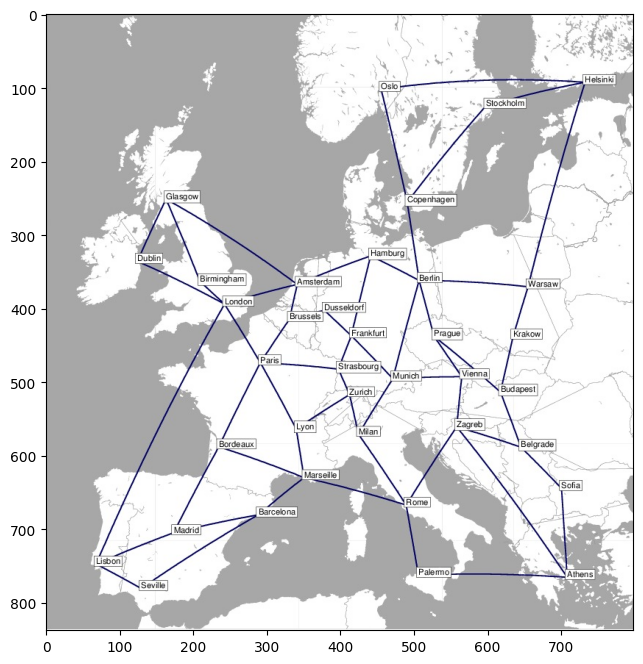

In [138]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

img = Image.open('cost266.jpg')
plt.imshow(img)

<div class="alert alert-block alert-info">
<font size="4"><font color=blue><b>DEFINE THE MODEL</b></font></font>
<br />
<br />
<b>PARAMETERS:</b>
<br /><br />
$G(V,E)$ $\longrightarrow$ $V$ set of nodes (vertices), $E$ set of links (edges or arcs)
<br /> <br />
$(i,j)\in E$ link between nodes $i$ and $j$
  <br /> <br />
$w_{ij}$ weight or marginal cost of link $(i,j)$
<br /> <br />
$C_{ij}$ capacity of link $(i,j)$
<br /> <br />
$d_{i,j}$ link distance
<br /> <br />
$D$ set of traffic demands  $\longrightarrow$ $(h_d, s_d, t_d)$, $h_d$ traffic demand $d$ from source node $s_d$ to destination node $t_d$
<br /> <br /> <br />
<b>VARIABLES:</b>
<br /><br />
$x_{ij}$ binary variable indicating if link $(i,j$) is active or not
<br /> <br />
$f_{ij}^d$ binary variable indicating if link $(i,j$) is active or not due to demand $d$
<br /> <br />
<br />

\begin{align}
&\\
\mbox{minimize } & \sum_{\forall (i,j)\in E} x_{ij} &&\\[8pt]
\mbox{such that }& \sum_{\forall (i,j)\in E} f_{ij}^d - \sum_{\forall (j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\ \forall i = s_d&&\nonumber\\[8pt]
& \sum_{\forall (i,j)\in E} f_{ij}^d - \sum_{\forall (j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\ \forall i = t_d\ \qquad \mbox{(redundant constraints)}&&\nonumber\\[8pt]
& \sum_{\forall (i,j)\in E} f_{ij}^d - \sum_{\forall (j,i)\in E} f_{ji}^d = 0\quad&&   \forall d \in D,\ \forall i \neq \{s_d,t_d\}&&\nonumber\\[8pt]
& \sum_{\forall d \in D}f_{ij}^{d}\cdot h_d <= C_{ij}\quad&&\forall (i,j)\in E&&\nonumber\\[8pt]
& f_{ij}^{d} <= x_{ij}\quad&&\forall d \in D,\ \forall (i,j)\in E&&\nonumber\\[8pt]
& x_{ij},\ f_{ij}^d\ \mbox{binary} \quad&&  \forall d \in D,\ \forall (i,j)\in E.&&\nonumber
\end{align}
</div>

In [139]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import networkx as nx

In [140]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)


# Flow capacity limits of links in Mb/s
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.cost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)


#####################
## MODEL VARIABLES ##
#####################

# Variable x indicates if each edge is used or not (for whatever demand);
# x[i,j]=1 edge (i,j) is used; x[i,j]=0 edge (i,j) is not used
model.x = Var(model.E, within=Binary, initialize=0)


# Variable f indicates if each edge transmits traffic of demand d or not;
# f[i,j,d]=1 edge (i,j) is used for demand d; f[i,j,d]=0 edge (i,j) is not used for demand d
model.f = Var(model.E, model.D, within=Binary, initialize=0)


########################
## OBJECTIVE FUNCTION ##
########################

# Minimize the Energy (the number of active links)
def energy_rule(model):
    return sum(model.x[i,j] for (i, j) in model.E)

model.energy = Objective(rule=energy_rule, sense=minimize)

# Minimize the cost (TO PROGRAM IN EXERCISE 5)
def totalcost_rule(model):
    return sum(model.cost[i,j] * model.x[i,j] for (i, j) in model.E)

model.totalcost = Objective(rule=totalcost_rule, sense=minimize)


# ACTIVATE OR DEACTIVATE the objective function according the exercise

model.energy.deactivate()
model.totalcost.activate()


#################
## CONSTRAINTS ##
#################

'''CONSTRAINT 1'''
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1

    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)


'''CONSTRAINT 2'''
def limit_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.capacity[i, j]

model.limit = Constraint(model.E, rule=limit_rule)

'''maintain the energy'''

def en_update_rule(model,i,j,d):
    return (model.f[i,j,d]) <= model.x[i, j]

model.en = Constraint(model.E, model.D, rule=en_update_rule)

# def disjoint_paths_rule(model, i, j):
#     return sum(model.f[i, j, d] for d in model.D) <= 1

# model.disjoint_paths = Constraint(model.E, rule=disjoint_paths_rule)


### SOLVE THE MODEL

In [141]:
# Construct the instance of the model and pass it to an (external) solver, in this case GLPK
# Data specified in an input file will override the data specified by the initialize options (if any)
opt = SolverFactory('glpk', executable = '/usr/bin/glpsol')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession1.dat')

results = opt.solve(instance)
instance.solutions.load_from(results)

### PRINT RESULTS

In [142]:
print ("\nENERGY (number of active links):", instance.energy())


ENERGY (number of active links): 7.0


In [143]:
for (i,j) in instance.E:
    if instance.x[i,j].value!=0:
        print('link (',i,', ',j,') is active', sep = '')

link (Amsterdam, Hamburg) is active
link (Barcelona, Marseille) is active
link (Brussels, Amsterdam) is active
link (Hamburg, Berlin) is active
link (Lyon, Paris) is active
link (Marseille, Lyon) is active
link (Paris, Brussels) is active


In [144]:
print("\n=======================")
print("TOTAL TRAFFIC PER LINK")
print("=======================")
for i in instance.V:
    for j in instance.V:
        if i==j: continue
        if (i,j) in instance.E:
            s = 0
            for d in instance.D:
                s = s + instance.f[i,j,d].value*instance.demand[d]
            if s != 0:
                print("f[",i, j, "] =",s)


def sort_links(instance, d):
    print("\n=====================================")
    print("PATH FLOW", d, "from",instance.source[d], "to", instance.destination[d])
    print("=====================================")
    i = instance.source[d]
    path=[]
    begin = True
    while begin:
        begin = False
        for j in instance.V:
            if (i,j) in instance.E:
                if instance.f[i,j,d].value != 0:
                    print ("f[",i, j,"] =",instance.f[i,j,d].value*instance.demand[d])
                    if i not in path: path.append(i)
                    if j not in path: path.append(j)
                    i = j
                    begin = True
                    break
    return path

paths = []
for d in instance.D:
    i = instance.source[d]
    for j in instance.V:
        if (i,j) in instance.E:
            if instance.f[i,j,d].value != 0:
                p=sort_links(instance, d)
                paths.append(p)
                print('\nPATH: ',p,'\n')
                break


TOTAL TRAFFIC PER LINK
f[ Amsterdam Hamburg ] = 10000.0
f[ Barcelona Marseille ] = 20000.0
f[ Brussels Amsterdam ] = 10000.0
f[ Hamburg Berlin ] = 10000.0
f[ Lyon Paris ] = 20000.0
f[ Marseille Lyon ] = 20000.0
f[ Paris Brussels ] = 10000.0

PATH FLOW 1 from Barcelona to Berlin
f[ Barcelona Marseille ] = 10000.0
f[ Marseille Lyon ] = 10000.0
f[ Lyon Paris ] = 10000.0
f[ Paris Brussels ] = 10000.0
f[ Brussels Amsterdam ] = 10000.0
f[ Amsterdam Hamburg ] = 10000.0
f[ Hamburg Berlin ] = 10000.0

PATH:  ['Barcelona', 'Marseille', 'Lyon', 'Paris', 'Brussels', 'Amsterdam', 'Hamburg', 'Berlin'] 


PATH FLOW 2 from Barcelona to Paris
f[ Barcelona Marseille ] = 10000.0
f[ Marseille Lyon ] = 10000.0
f[ Lyon Paris ] = 10000.0

PATH:  ['Barcelona', 'Marseille', 'Lyon', 'Paris'] 



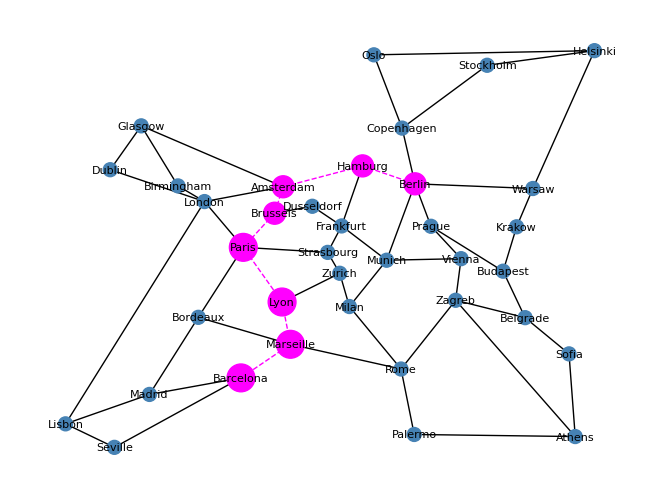

In [145]:
def show_paths(paths,color,custom_node_positions=None):
    plt.figure()

    if custom_node_positions==None:
        pos = nx.spring_layout(G)
    else:
        pos=custom_node_positions

    list_edges = list(G.edges())
    list_nodes = list(G.nodes())

    edges_paths=[]
    for i,p in enumerate(paths):
        edges_paths.append(list(zip(p,p[1:])))

    edge_colors = ['black' for edge in G.edges()]
    edge_style = ['solid' for edge in G.edges()]


    for i,p in enumerate(edges_paths):
        for edge in G.edges():
            if (edge[0],edge[1]) in p or (edge[1],edge[0]) in p:
                edge_colors[list_edges.index(edge)] = color
                edge_style[list_edges.index(edge)] = 'dashed'

    nodecol = ['steelblue' for node in G.nodes()]
    node_size = [100 for node in G.nodes()]

    for i,p in enumerate(paths):
        for node in G.nodes():
            if node in p:
                nodecol[list_nodes.index(node)] = color
                node_size[list_nodes.index(node)]+=150


    nx.draw(G,pos,with_labels = True,font_size = 8, font_color = 'black',\
            edge_color = edge_colors, style = edge_style, node_size = node_size,\
            node_shape = 'o', node_color = nodecol)


# Create the graph with nodes and links attributes
G = nx.Graph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j], 'cost':instance.cost[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Show paths on the graph
show_paths(paths,'magenta',node_pos)

---


<div class="alert alert-block  alert-success">
<font size="4"><font color=green><b>EXERCISES</b></font></font>
</div>

-----------------------------------------------------------------------------------------------------------------------
### <font color=blue><b>EXERCISE 1</b></font>.-

####  Execute the code as it is now and analyze the result. What is the reason for the obtained result?

In [146]:
'''The path from Barcelona to Berlin is
PATH:  ['Barcelona', 'Seville', 'Lisbon', 'London', 'Paris', 'Strasbourg', 'Frankfurt', 'Hamburg', 'Berlin'].
Everytime the next node is selected based on the capacity, also minimizing the energy. As we are not updating the energy, it is 0 everytime.
So, the only thing under consideration is to reach the destination with whatever link it decides.'''

"The path from Barcelona to Berlin is \nPATH:  ['Barcelona', 'Seville', 'Lisbon', 'London', 'Paris', 'Strasbourg', 'Frankfurt', 'Hamburg', 'Berlin'].\nEverytime the next node is selected based on the capacity, also minimizing the energy. As we are not updating the energy, it is 0 everytime.\nSo, the only thing under consideration is to reach the destination with whatever link it decides."

-----------------------------------------------------------------------------------------------------------------------
### <font color=blue><b>EXERCISE 2</b></font>.-

####  Compare the mathematical model and the programmed model. Add any code, if necessary, and rerun the model. Compare the result with the previous exercise and explain what happens.

In [147]:
'''The mathematical model has its energy optimized in a constraint. But it is not there in programmed model.

Updated Code:
def en_update_rule(model,i,j,d):
    return (model.f[i,j,d]) <= model.x[i, j]

model.en = Constraint(model.E, model.D, rule=en_update_rule)
'''


'The mathematical model has its energy optimized in a constraint. But it is not there in programmed model.\n    \nUpdated Code:\ndef en_update_rule(model,i,j,d):\n    return (model.f[i,j,d]) <= model.x[i, j]\n    \nmodel.en = Constraint(model.E, model.D, rule=en_update_rule)\n'

In [148]:
'''After adding this piece of code, the solution is-
PATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] and the energy updated to 5.0.
As we are now updating the energy, the path takes the least amount of links to minimize the energy'''

"After adding this piece of code, the solution is-\nPATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] and the energy updated to 5.0. \nAs we are now updating the energy, the path takes the least amount of links to minimize the energy"

-----------------------------------------------------------------------------------------------------------------------
### <font color=blue><b>EXERCISE 3</b></font>.-

####  Consider two simultaneous demands: one from Barcelona to Berlin and the other from Barcelona to Paris, both of 10000 traffic units (modify the input file). What are the results in terms of energy and paths used for each demand? Explain the reason for obtaining the resulting paths

In [149]:
'''The path from Barcelona to Berlin is
PATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']. Energy=5.0
The path from Barcelona to Paris is
PATH:  ['Barcelona', 'Marseille', 'Bordeaux', 'Paris']. Energy=7.0
We got the resulting paths because it is the most optimized path for supporting our traffic with minimal energy.
As many links are active, the energy increases and there is one common node in both paths as this minimizes the links.'''

"The path from Barcelona to Berlin is \nPATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']. Energy=5.0\nThe path from Barcelona to Paris is\nPATH:  ['Barcelona', 'Marseille', 'Bordeaux', 'Paris']. Energy=7.0\nWe got the resulting paths because it is the most optimized path for supporting our traffic with minimal energy.\nAs many links are active, the energy increases and there is one common node in both paths as this minimizes the links."

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 4</b></font>.-


#### Modify the problem (adding a new constraint) to calculate disjoint paths for the demands to maximize the energy savings (i.e., minimize the number of active links). Compare the obtained result with the initial one.
-----------------------------------------------------------------------------------------------------------------------

In [150]:
'''With Disjoint path- 8.0'
Without disjoint path- 7.0
As we are not using the same node for 2 destinations, there is a new active link created.'''

"With Disjoint path- 8.0'\nWithout disjoint path- 7.0\nAs we are not using the same node for 2 destinations, there is a new active link created."

-----------------------------------------------------------------------------------------------------------------------
### <font color=blue><b>EXERCISE 5</b></font>.-


#### Modify the problem to calculate paths for the demands to minimize the total cost  (programming the second objective function and using the activate or deactivate command) . Compare the obtained result with the initial one with and without the disjointness constraint.
--------------

In [151]:
'''Energy without active totalcost and without disjointness constraint- 7.0
Energy without active totalcost and with disjointness constraint- 8.0
Energy with active totalcost and without disjointness constraint- 7.0
Energy with active totalcost and with disjointness constraint- 10.0
the paths also change during these simulations.'''



'Energy without active totalcost and without disjointness constraint- 7.0\nEnergy without active totalcost and with disjointness constraint- 8.0\nEnergy with active totalcost and without disjointness constraint- 7.0\nEnergy with active totalcost and with disjointness constraint- 10.0\nthe paths also change during these simulations.'